In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
copper_model_data = pd.read_csv("/workspaces/dev/Industrial_Copper_Modelling/copper_final.csv")
copper_model_data.shape

(181667, 23)

In [50]:
copper_model_data.head(2)

,item type_IPL,item type_Others,item type_PL,item type_S,item type_SLAWR,item type_W,item type_WI,quantity tons,country,status,...,material_ref,product_ref,selling_price,date_differ,item_date_day,item_date_month,item_date_year,delivery date_day,delivery date_month,delivery date_year
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.191942,28.0,Won,...,8,1670798778,6.749931,91,1,4,2021,1,7,2021
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.096583,25.0,Won,...,100645,1668701718,6.953684,0,1,4,2021,1,4,2021


CLASSIFICATION MODEL

In [11]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 9.2 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # XGBoost typically uses the alias "xgb"

In [9]:
copper_model_data["status"].unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [89]:
copper_classify_data = copper_model_data[(copper_model_data["status"]=="Won") | (copper_model_data["status"]=="Lost")]

In [90]:
copper_classify_data.shape

(150445, 23)

In [91]:
xc = copper_classify_data.drop(columns=['status'])
yc = copper_classify_data["status"]

Decision Tree

In [64]:
x_train,x_test,y_train,y_test = train_test_split(xc,yc,stratify=y)
print(x_train.shape)
print(x_test.shape)

(112833, 22)
(37612, 22)


In [14]:
# Training the Model
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [15]:
# y_train_pred ==> used for comparison
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

Train score 1.0
Test score 0.9416941401680314
Train Confusion matrix


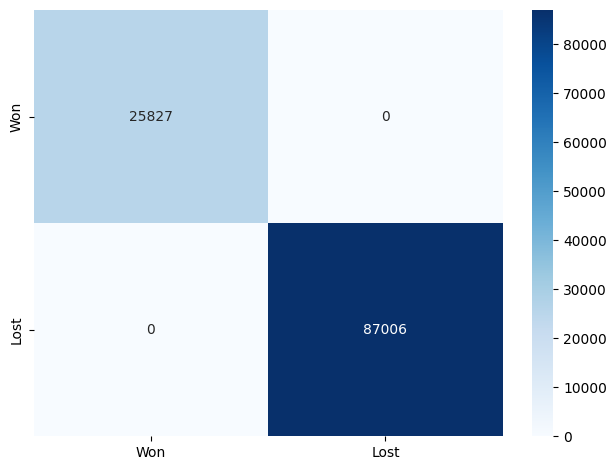

Test Confusion matrix


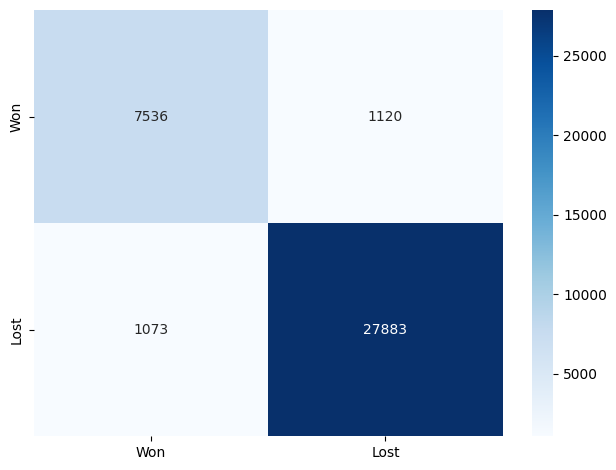

In [21]:
# Confusion Matrix & Accuracy -- Test Data compared with Train Data
def plot_confusionmatrix(y_pred,y,dom):
    classes = ['Won','Lost']
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_pred,y)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

Random Forest

In [92]:
# Splitting the Data 
X_train, X_test, Y_train, Y_test = train_test_split(xc, yc, test_size = 0.33, random_state = 42)

In [93]:
# instantiate the classifier
rfc1 = RandomForestClassifier(n_estimators=10,random_state=0)  
# fit the model
rfc1.fit(X_train, Y_train)
# Predict the Test set results
Y_pred = rfc1.predict(X_test)
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Model accuracy score with 10 decision-trees : 0.9571


In [94]:
# instantiate the classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators => number of Decision Tree taken into consideration  
# fit the model
rfc.fit(X_train, Y_train)
# Predict the Test set results
Y_pred = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, Y_pred)))

Model accuracy score with 100 decision-trees : 0.9647


In [36]:
# view the feature scores
# Sort the feature columns based on its importance
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False) 
feature_scores

date_differ            0.141680
country                0.092981
item_date_day          0.088131
quantity tons          0.087676
selling_price          0.086489
application            0.070564
material_ref           0.063138
thickness              0.059487
product_ref            0.052098
item_date_month        0.048537
item type_S            0.047926
delivery date_month    0.047903
width                  0.044860
item type_W            0.030037
delivery date_day      0.017365
item_date_year         0.008675
delivery date_year     0.006744
item type_PL           0.005385
item type_Others       0.000204
item type_WI           0.000118
item type_IPL          0.000002
item type_SLAWR        0.000000
dtype: float64

XGBoost Classifier

In [67]:
ycx = yc.map({"Won":1,"Lost":0})


In [68]:
ycx.value_counts()

status
1    116009
0     34436
Name: count, dtype: int64

In [32]:
# Train and test split using sklearn
Xi_train, Xi_test, Yi_train, Yi_test= train_test_split(xc, ycx, test_size=.33, random_state=123)

In [37]:
# Instatiate a XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=123)

## Set max_depth to be 10 instead of 100
xgb_clf.set_params(n_estimators=150)

# Fit it to the training set
xgb_clf.fit(Xi_train, Yi_train)

# Predict the labels of the test set
preds = xgb_clf.predict(Xi_test)
preds

array([1, 0, 1, ..., 0, 1, 1])

In [38]:
# Calculate the accuracy
accuracy = float(np.sum(preds==Yi_test))/Yi_test.shape[0]

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.9373980300924527


Accuracy Scores of different Classifiers
- Decision Tree : 0.9416
- Random Forest Tree (n_estimators = 10) : 0.9571
- Random Forest Tree (n_estimators = 100) : 0.9647
- XGBoost Classifier : 0.9373

So Random Forest Classifier with n_estimators as 100 is chosen

REGRESSION MODEL

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [70]:
copper_regress_data = copper_model_data.copy()

In [71]:
copper_regress_data["status"] = copper_regress_data["status"].map({'Won':8,'Draft':1,"To be approved":4,"Lost":0,"Not lost for AM":6, "Wonderful":7,"Revised":2,"Offered":5,"Offerable":3})

In [72]:
xr = copper_regress_data.drop("selling_price",axis=1)
yr = copper_regress_data["selling_price"]

In [73]:
xf_train, xf_test, yf_train, yf_test = train_test_split(xr, yr, test_size=0.2, random_state=42)

In [75]:
# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(xf_train, yf_train)

RandomForestRegressor(random_state=42)

In [87]:
yf_pred = rf_regressor.predict(xf_test)
yf_pred

array([6.49046284, 6.74425236, 6.30985773, ..., 6.65467632, 6.77319676,
       6.71331561])

In [78]:
# Calculate R2 score
r2 = r2_score(yf_test, yf_pred)
print(f"R2 Score: {r2:.2f}")


R2 Score: 0.96


XGBoost Regressor

In [79]:
xg_train, xg_test, yg_train, yg_test = train_test_split(xr, yr, test_size=0.2, random_state=42)

In [82]:
# Initialize the XGBRegressor
xgb_regressor = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_regressor.fit(xg_train, yg_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [88]:
yg_pred = xgb_regressor.predict(xg_test)
yg_pred

array([6.5032425, 6.79369  , 6.2854137, ..., 6.6497126, 6.7759485,
       6.679069 ], dtype=float32)

In [86]:
r2 = r2_score(yg_test, yg_pred)
print(f"R2 Score: {r2:.2f}")

R2 Score: 0.96


Accuracy Scores of different Regressors :
- Random Forest Regressor : 0.96
- XGBoost Regressor : 0.96

Both have similar accuracy - anyone can be chosen for prediction